<a href="https://colab.research.google.com/github/TeamMAMI/MAMI/blob/PlotResults/main_plot_history.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: Turn on GPU for this notebook.*

## Dependencies and Libraries

In [1]:
# download the required pacakges
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 9.6 MB/s 


In [2]:
# import the libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

## Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the data
### data_path is the path of the csv file

data_path = "/content/drive/Shareddrives/team MAMI/MAMI/TRAIN/training.csv"
df = pd.read_csv(data_path, delimiter="\t")
df.head(5)

,file_name,misogynous,shaming,stereotype,objectification,violence,Text Transcription
0,1.jpg,0,0,0,0,0,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...


## Data Summary and Preprocessing

In [5]:
# checking if the classes are balanced
df['misogynous'].value_counts()

1    5000
0    5000
Name: misogynous, dtype: int64

The classes are evenly distributed (i.e. balanced class).

In [6]:
# splitting the data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Text Transcription'],df['misogynous'], stratify=df['misogynous'], test_size=0.25)

## BERT Implementation

In [7]:
# downloading the pre-trained BERT model from tfhub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Functional model below.

In [8]:
# initializing BERT layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # input layer
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# initializing NN layers

### The Dropout layer randomly sets input units to 0 with a frequency of rate at 
### each step during training time, which helps prevent overfitting
### Source: https://keras.io/api/layers/regularization_layers/dropout/
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) # 0.1% neuron is dropped out randomly
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l) # 1 neuron tells if the text is misogynous or not (i.e. 1 or 0)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

## Model Training

In [10]:
# accuracy metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
235/235 [==============================] - 75s 278ms/step - loss: 0.8134 - accuracy: 0.5183 - precision: 0.5180 - recall: 0.5251 - val_loss: 0.6765 - val_accuracy: 0.5756 - val_precision: 0.5775 - val_recall: 0.5632
Epoch 2/5
235/235 [==============================] - 64s 273ms/step - loss: 0.7406 - accuracy: 0.5376 - precision: 0.5378 - recall: 0.5347 - val_loss: 0.6648 - val_accuracy: 0.6232 - val_precision: 0.6410 - val_recall: 0.5600
Epoch 3/5
235/235 [==============================] - 64s 273ms/step - loss: 0.7108 - accuracy: 0.5435 - precision: 0.5435 - recall: 0.5427 - val_loss: 0.6577 - val_accuracy: 0.6392 - val_precision: 0.6921 - val_recall: 0.5016
Epoch 4/5
235/235 [==============================] - 64s 272ms/step - loss: 0.6912 - accuracy: 0.5639 - precision: 0.5657 - recall: 0.5499 - val_loss: 0.6539 - val_accuracy: 0.6236 - val_precision: 0.5971 - val_recall: 0.7600
Epoch 5/5
235/235 [==============================] - 64s 272ms/step - loss: 0.6845 - accuracy: 0

In [12]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

79/79 [==============================] - 16s 204ms/step - loss: 0.6518 - accuracy: 0.6476 - precision: 0.7178 - recall: 0.4864


In [13]:
print(f'loss: {loss}')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')

loss: 0.6517605781555176
accuracy: 0.647599995136261
precision: 0.7178276181221008
recall: 0.4864000082015991


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


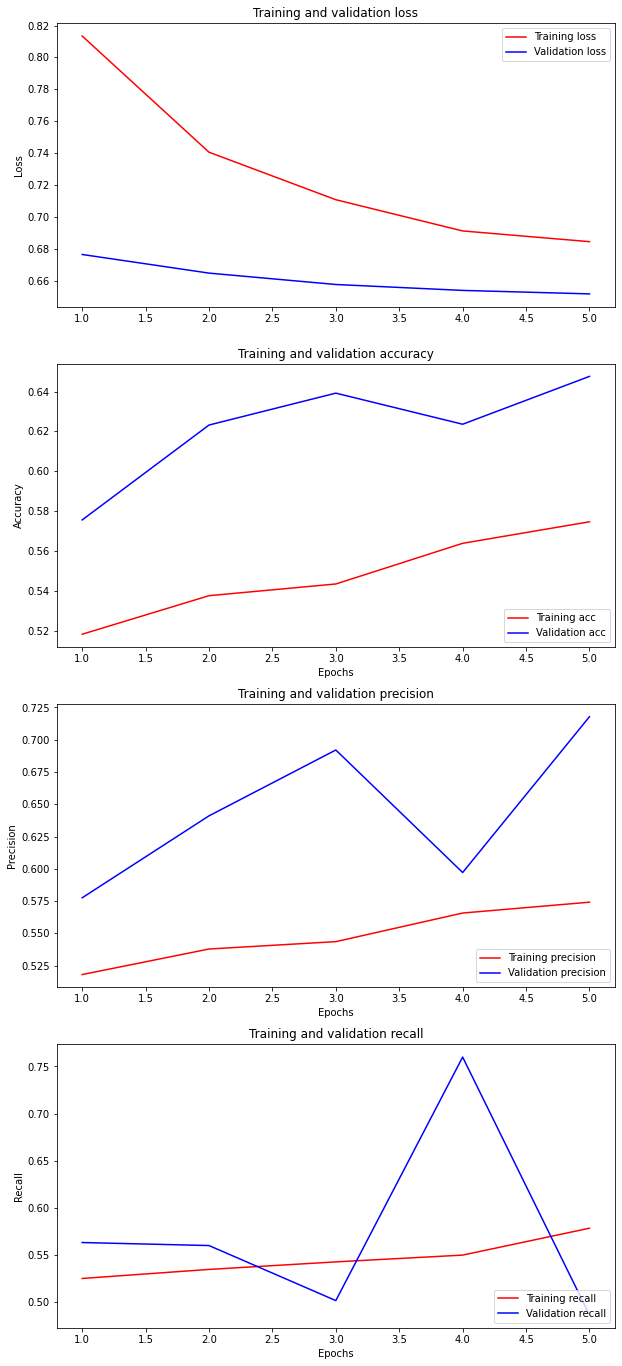

In [17]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
lo = history_dict['loss']
val_lo = history_dict['val_loss']
prec = history_dict['precision']
val_prec = history_dict['val_precision']
rec = history_dict['recall']
val_rec = history_dict['val_recall']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 24))
fig.tight_layout()

plt.subplot(4, 1, 1)
# r is for "solid red line"
plt.plot(epochs, lo, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_lo, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(4, 1, 3)
plt.plot(epochs, prec, 'r', label='Training precision')
plt.plot(epochs, val_prec, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')

plt.subplot(4, 1, 4)
plt.plot(epochs, rec, 'r', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')